## 6. サポートベクトルデータ記述法による異常検知
### 6.1 データを囲む最小の球
$D=\{\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(N)}\}$のような、ラベルが与えられていないデータを考える。  
$D$の中には異常標本が含まれていないか、含まれていたとしても圧倒的少数であるとする。  
「標本集合のほぼ全体を囲む球を作り、その球に入りきらなかったものを異常と判定する」という考え方は自然である。  

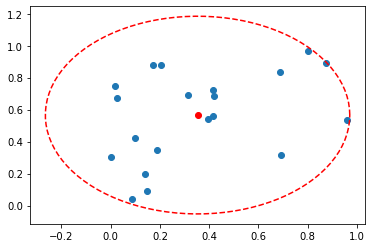

In [9]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def make_circle(x, y, r, theta):
    return np.concatenate([[x + r * np.cos(theta)], [y + r * np.sin(theta)]], axis=0).T

def find_near_k(x1, x2, k):    
    dist = np.sum((x1 - x2)**2, axis=1)
    near5 = x1[np.argsort(dist)[:k]]
    dist5 = dist[np.argsort(dist)[k-1]]
    return near5, dist5

x1 = np.random.rand(20, 2)

x2 = np.mean(x1, axis=0)

near, dist = find_near_k(x1, x2=x2, k=20)

theta = np.linspace(0, 2*np.pi, 100)

plt.scatter(x1[:,0], x1[:,1]);
plt.scatter(x2[0], x2[1], color=['red']);

c = make_circle(x2[0], x2[1], r=np.sqrt(dist), theta=theta)

plt.plot(c[:,0], c[:,1], '--', color='red');

データを含むという条件のもとで、できる限り小さい球を求める。  
これは次のような最適化問題で表せる。
$$
\min_{R^2,\boldsymbol{b}}{R^2}\ ただし条件\ |\boldsymbol{x}^{(n)}-\boldsymbol{b}|^2\leq R^2
$$
ここで、$n=1,\cdots,N$で$|\boldsymbol{a}|^2=\boldsymbol{a}^T\boldsymbol{a}$であり、$R$は球の半径、$\boldsymbol{b}$は中心の位置ベクトルを表す。  
$\boldsymbol{x}^{(n)}$に対して、半径2乗に$u^{(n)}$分だけの「遊び」を許したうえで次の問題を解くことにする。  
$$
\min_{R^2,\boldsymbol{b},\boldsymbol{u}}\biggl\{R^2+C\sum_{n=1}^Nu^{(n)} \biggr\}\ subject\ to\ |\boldsymbol{x}^{(n)}-\boldsymbol{b}|^2\leq R^2+u^{(n)}
$$
$C$は**正則化定数**と呼ばれる。  
また、$u^{(n)}\geq 0$でなければならない。  
  
解が$\{R^{2*},\boldsymbol{b}^*,\boldsymbol{u}^*\}$が求まっているとする。  
直感的に異常度を「球からはみ出した長さ」として$a(\boldsymbol{x}')=|\boldsymbol{x}'-\boldsymbol{b}^*|＾2-R^{2*}$のように定義できる。  
2乗を展開して、
$$
a(\boldsymbol{x}')=K(\boldsymbol{x}',\boldsymbol{x}')-2K(\boldsymbol{b}^*,\boldsymbol{x}')+K(\boldsymbol{b}^*,\boldsymbol{b}^*)-R^{2*}
$$
と表しておく。  
ただし、$K(・,・)$は引数同士の内積を表す。(あとで拡張した定義を与える。)  
最適化問題を解くと、異常と正常を分ける球が、ごく少数の訓練標本で表されるという結果になる。  
それが、**サポートベクトルデータ記述法(支持ベクトルデータ記述法)**と呼ばれる由来である。  
この手法は、**1クラスサポートベクトルマシン**とも呼ばれる。

### 6.2 双対問題への変換とカーネルトリック
非線形制約を持つ最適化問題を「双対問題」に変換することで、非線形制約を消去する手法がある。  
それを使えないか検討する。  
ラグランジュ関数$L$を次のように定義する。  
$$
\begin{align}
L(R^2, \boldsymbol{b}, \boldsymbol{u}, \boldsymbol{\alpha}, \boldsymbol{\beta})&=R^2+C\sum_{n=1}^Nu^{(n)}-\sum_{n=1}^N\beta_nu^{(n)}-\sum_{n=1}^N\alpha_n\bigl\{R^2+u^{(n)}-|\boldsymbol{x}^{(n)}-\boldsymbol{b}|^2 \bigr\}
\end{align}
$$
もとの変数$R^2$、$\boldsymbol{b}$、$\boldsymbol{u}$について最大化するため以下の計算を行う。  

$$
0=\frac{\partial L}{\partial R^2}=1-\sum_{n=1}^N\alpha_n\\
\boldsymbol{0}=\frac{\partial L}{\partial \boldsymbol{b}}=2\sum_{n=1}^N\alpha_n\boldsymbol{b}-2\sum_{n=1}^N\alpha_n\boldsymbol{x}^{(n)}\\
0=\frac{\partial L}{\partial u^{(n)}}=C-\beta_n-\alpha_n
$$

これを使って$R^2$、$\boldsymbol{b}$、$\boldsymbol{u}$を消去する。  
$$
\begin{align}
l(\boldsymbol{\alpha},\boldsymbol{\beta})&=\min_{R^2,\boldsymbol{b},\boldsymbol{u}}L(R^2, \boldsymbol{b}, \boldsymbol{u}, \boldsymbol{\alpha}, \boldsymbol{\beta})\\
&=\sum_{n=1}^N\alpha_nK_{n,n}-\sum_{n=1}^N\alpha_n\alpha_{n'}K_{n,n'}
\end{align}
$$

ただし、$K_{n,n'}=K(\boldsymbol{x}^{(n)},\boldsymbol{x}^{(n')})$と略記している。  
ラグランジュ乗数$\boldsymbol{\alpha},\boldsymbol{\beta}$については、KKT条件から、非負条件$\alpha_n\geq0,\beta_n\geq0$が付される。  
明らかに
$$
0\leq\beta_n=C-\alpha_n
$$
が成り立つので、$\beta_n$は$\alpha_n$が求まれば決定できる。  
$\beta_n$に対する非負条件から$\alpha_n\leq C$という条件を付す。  
以上まとめると、解くべき問題は、
$$
\max_{\alpha}\biggl\{\sum_{n=1}^N\alpha_nK_{n,n}-\sum_{n,n'=1}^N\alpha_n\alpha_{n'}K_{n,n'} \biggr\}\\
subject\ to\ 0\leq\alpha_n\leq C(n=1,\cdots,N)
$$
この双対問題は、通常の二値分類問題に使われる支持ベクトル分類器の双対問題と本質的に同じである。  
通常、LIBSVMなどの既存のプログラムを用いて数値計算を行う。  
具体的な最適化手法としては、SMO法と双対座標降下法が代表的である。  


内積$K$を、たとえばRBF(動径基底関数)カーネルを使って、
$$
K(\boldsymbol{x},\boldsymbol{x'})←\exp\{-\sigma|\boldsymbol{x}-\boldsymbol{x'}|^2\}
$$
のように置き換えたと考える。  
これは、元の座標を、内積が上記の関数で与えるような座標に非線形変換したとに対応している。  
内積を与えることで非線形変換をしたことにする考え方を**カーネルトリック**と呼ぶ。  
内積として与える関数$K(\boldsymbol{x},\boldsymbol{x'})$のことを**カーネル関数**と呼ぶ。

### 6.3 解の性質と分類
最適解$\alpha^*$が求まったら、KKT条件を逆に使い、元の解を求める。  
まず、
$$
\boldsymbol{b}^*=\sum_{n=1}^N\alpha_n^*\boldsymbol{x}^{(n)}
$$
が得られる。  
また、KKT条件の式に対応して、次の2種類の式が成り立つ。  
$$
\begin{align}
\alpha_n\bigl\{R^2+u^{(n)}-|\boldsymbol{x}^{(n)}-\boldsymbol{b}|^2 \bigr\}&=0\\
(C-\alpha_n^*)u^{(n)}&=0
\end{align}
$$
この条件式から、以下の3つの場合があることが分かる。  

1. 